# Vector - Technical Analysis

# **Contents**

---
* [**1. Introduction**](#1.-Introduction)
* [**2. Data Overview**](#2.-Data-Overview)
* [**3. Assumptions and Limitations**](#3.-Assumptions-and-Limitations)
* [**4. Importing Packages**](#4.-Importing-Packages)
* [**5. Importing Data**](#5.-Importing-Data)
* [**6. Merging Dataframes**](#6.-Merging-Dataframes)
* [**7. Creating Features**](#7.-Creating-Features)
* [**8. Exploring UoM Consumption**](#8.-Exploring-UoM-Consumption)
* [**9. Modelling the Proportion of HVAC Consumption**](#9.-Modelling-the-Proportion-of-HVAC-Consumption)
* [**10. Exploring NEM Price**](#10.-Exploring-NEM-Price)
* [**11. Investigating HVAC Cost**](#11.-Investigating-HVAC-Cost)
* [**12. Investigating the Potential Savings**](#12.-Investigating-the-Potential-Savings)
* [**13. Investigating the 24th and 25th of January 2019 (The Day Before The Blackouts)**](#13.-Investigating-the-24th-and-25th-of-January-2019-(The-Day-Before-The-Blackouts))
* [**14. Summary**](#14.-Summary)


## 1. Introduction
---
### Residential electricity load profiles

#### You have been provided an historical sample of residential smart meter load data for 50 residential customers and temperature data for Auckland for the full year 2015. Smart meters measure electricity consumption (kWh) in 30-min intervals. You have also received hourly temperature data for Auckland in 2015.

You are asked to please complete the following 2 parts of analysis:

1. The customer connections team is helping a property developer to size infrastructure for a new residential development and wants to know what the load as a group may look like and what variations may be expected. They ask you to determine typical daily load profile(s) (24 hours from midnight to midnight) for winter and summer at aggregate level. Please comment in the script on how you chose to define typical and why.

2. The customer connections team also considers asking the developer to put additional insulation into certain houses but given the current budget constraints due to COVID-19, it knows that the developer can only do this for the houses with the highest gain. Please determine the 10% of customers who will benefit the most.

## 2. Data Overview
---

### Smart Meter Load Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_MeterSample50.csv
#####  
##### Information Overview:
 - **TradingPeriod**:  30 minute time intervals that reset each day (1-48)
 - **MeterPollDateKey**:  A date key (YYYYMMDD)
 - **ICPKey**:  Installation control point number for residential smart meters (contains unique 50 entries)
 - **ElecCons_kWh**:  Data on kilowatt hour electricity consumption within the trading period (e.g. the **ElecCons_kWh** corresponding to the **TradingPeriod** of 1 would be the the average rate of consumption between 12am and 12:30am in kWh. so a **ElecCons_kWh** of 0.2 would amount to using 0.1 kW of electricity)
 
### - Consumption reading?

### Temperature Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_Weather2015.csv
#####  
##### Information Overview:
 - **HourStart**: Time of day in 1 hour time intervals (0-23)
 - **DateKey** : A date key (YYYYMMDD)
 - **Temp_DegCelsius**: The temperature. For this analysis, what i consider to be, the simplist interpretation will be used which is that the feature **Temp_DegCelsius** is the temperature at the start of the hour (e.g. the value corresponding to an **HourStart** of 0 is the temperture at 12am). The way that the **HourStart** feature is worded leaves me wondering if this is somthing more along the lines of the average temperature over the hour that started at 12am or even the temperature at the midpoint of the hour (e.g. the temperature at 12:30am) clarifying this would be recomended as it effects how the meter data can be joined on.

### I had a brief look for other sources of weather data as I suspect that rain and windchill factor will have a significant impact on percieved temperature and heating/cooling electricity consumption...

## 3. Assumptions and Limitations
---
      
1. Internal temperature; at this stage there is no internal temperature data. The ideal case would be the site by site thermostat readings.    The rate of heat transfer?.
 
2. Summer ends on Saturday, 21 March and winter starts on Sunday, 22 June and ends on Wednesday, 23 September and summer starts again on Monday, 22 December (source: google). This assumes that the property developer is interested in the more extreme temperature profiles.

3. Interpolating weather values...  

4. Other wheather effects...
  
5. Temperature inside the home (For part two) is energy just being consumed for heat or other reasons...

6. I've decided not to remove outliers as although some of them look very large no points look erorneuos and the variations are mentiond as being of interest

## 4. Importing Packages
---

In [1]:
# File system management
import os
# Setting the directory to the parent directory
os.chdir('..')

# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import random

# Datetime for handling datetime variables
import datetime as dt

# Importing algorithms
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# Sklearn label encoder
from sklearn.preprocessing import LabelEncoder

# Sklearn data splitting
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Sklearn importing measurement metric for temp correlation of consumption
from sklearn.metrics import mean_squared_error

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 5. Importing Data
---

### Importing The Meter Sample Dataset

In [2]:
# Importing the meter dataset as a pandas dataframe
meter_df = pd.read_csv('data/Data_MeterSample50.csv')

In [3]:
meter_df.head()

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
0,5972076,20150101,1,0.16
1,5972076,20150101,2,0.17
2,5972076,20150101,3,0.13
3,5972076,20150101,4,0.15
4,5972076,20150101,5,0.16


In [4]:
# Note that there is a maximum trading period of 50 which I'm assuming is because of daylight savings causing an hour to appear twice (and conversly there is probably a day that only went up to 46.
# Ideally we should create a datetime variable and adjust to UTC to acount for this shift
meter_df.describe(include='all')

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
count,8.759500e+05,8.759500e+05,875950.000000,875950.000000
mean,6.155496e+06,2.015067e+07,24.501564,0.500849
std,2.016792e+05,3.450066e+02,13.853280,0.550925
min,5.972076e+06,2.015010e+07,1.000000,0.000000
25%,6.015713e+06,2.015040e+07,13.000000,0.119000
50%,6.033299e+06,2.015070e+07,25.000000,0.294900
75%,6.402389e+06,2.015100e+07,37.000000,0.685900
max,6.578393e+06,2.015123e+07,50.000000,5.710000


In [5]:
# Converting the time to a time feature
meter_df['Time'] = pd.to_datetime(meter_df['TradingPeriod'])
meter_df['Time'] = (meter_df['Time'].dt
                                    .time)

### Importing The Hourly Temperature Dataset

In [6]:
# Importing and concatenating the monthly readings
temp_df = pd.read_csv('data/Data_Weather2015.csv')

In [7]:
temp_df.head()

,DateKey,HourStart,Temp_DegCelsius
0,20150101,0,19.00
1,20150101,1,18.75
2,20150101,2,17.25
3,20150101,3,16.50
4,20150101,4,16.50


In [8]:
# Note: No additional hours from daylight savings but there will probably be a day with a repeated hour and a day with a missing hour.
temp_df.describe(include='all')

,DateKey,HourStart,Temp_DegCelsius
count,8.760000e+03,8760.000000,8760.000000
mean,2.015067e+07,11.500000,15.206117
std,3.450216e+02,6.922582,4.089467
min,2.015010e+07,0.000000,3.500000
25%,2.015040e+07,5.750000,12.250000
50%,2.015070e+07,11.500000,15.000000
75%,2.015100e+07,17.250000,18.000000
max,2.015123e+07,23.000000,26.500000


## 6. Merging Dataframes
---

#### In order to merge the dataframe the time features (DataWeather2015:HourStart and Data_MeterSample50:TradingPeriod) need to be alligned.
---

##### With the assumption that the temperature reading has been taken on the hour and the meter reading is the rate of consumption derrived from the usage over the half hour period starting on the half hour in order to allign the datasets there are three relativly simple options in order from simplest to most complicated:
1. Join the meter reading on at the nearest hour e.g. the meter reading with a **TradingPeriod** of 4 (1:30am-2:00am) and 5 (2:00am-2:30am) would be joined onto the nearest temperature reading which has an **HourStart** of 2 (2:00am). 
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - The temperature readings would not accuratly correspond to the meter readings (there would be a 15m shift from the center of the trading periods).
2. Aggregate the meter readings to the nearest hour (by taking the mean) of the two values e.g. if there was a **ElecCons_kWh** of 0.3 at a **TradingPeriod** of 4 (1:30am-2:00am) and a **ElecCons_kWh** of 0.4 at a **TradingPeriod** of 5 (2:00am-2:30am) would be aggregated into a **ElecCons_kWh** of 0.35 over a trading period of 1 hour centered around 2:00am.
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - Granularity of the meter readings would be reduced.
3. Interpolating the temperature measurements to find the temperature on the half hour starting on the quarter hour (this is to get a range of ) of the two values e.g. if there was a **ElecCons_kWh** of 0.3 at a **TradingPeriod** of 4 (1:30am-2:00am) and a **ElecCons_kWh** of 0.4 at a **TradingPeriod** of 5 (2:00am-2:30am) would be aggregated into a **ElecCons_kWh** of 0.35 over a trading period of 1 hour centered around 2:00am.
- Note: 
    - Granularity is maintained.
    - Temperature readings would only be an interpolation (not 100% accurate but better then the other two options).
    - A bit more work.
4. Sourcing more granular weather data. This would likly also lead to more meteorological features such as rain, wind etc. which I expected to have a significant effect on the heating of the house. I had a bit of a look into finding this data but granular historic weather data seems to only be readily availible behind paywalls.

In [9]:
# # Merging the UoM clarity and AEMO NEM dataframes
# df = pd.merge(meter_df, NEM_df, how='inner', on=['Date', 'Time'])

In [10]:
# # Merging the master dataframe and the BoM Climate dataframe
# df = pd.merge(df, BoM_df, how='left', on=['Date'])

## 7. Creating Features
---

#### Creating Weekday and Month Features

In [45]:
# Converting the date to a datetime feature
meter_df['Date'] = pd.to_datetime(meter_df['MeterPollDateKey'], format='%Y%m%d')
# meter_df['Date'] = (meter_df['Date'].dt
#                                     .date)

In [50]:
# Creating a winter, summer and other feature
def season(df):
    if ((df['Date'] <= dt.date(2015, 3, 21)) | (df['Date'] >= dt.date(2015, 12, 22))):
        val = 'Summer'
    elif ((df['Date'] >= dt.date(2015, 6, 22)) & (df['Date'] <= dt.date(2015, 9, 23))):
        val = 'Winter'
    else:
        val = 'Other'
    return val

meter_df['Season'] = meter_df.apply(season, axis=1)

In [51]:
# Creating a plotable dataframe
kWh_by_season_df = pd.DataFrame(meter_df.groupby(['Season','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_season_df.reset_index(level=['Season','TradingPeriod'], inplace=True)

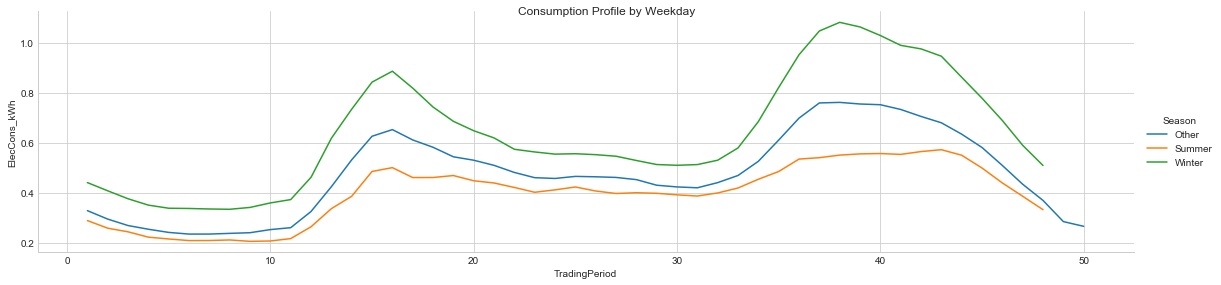

In [52]:
# Plotting the distributions of price against weekday. 
# This shows clearly different profiles with winter being the most intense consumption suggesting that electric heating or more time spent in doors might be the biggest factors.
line_plot(data=kWh_by_season_df, group='Season', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [61]:
# Creating a dictionary for the weekend flag
season_dict = {"Summer": 0, "Winter": 1, "Other": 2}
meter_df['Season_Int'] = meter_df['Season'].map(season_dict)

In [33]:
# Creating a weekday feature
meter_df['Weekday'] = (meter_df['Date'].dt
                                       .weekday)
# Creating a maping dictionary
day_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",4: "Friday", 5: "Saturday", 6: "Sunday"}
meter_df['Weekday'] = meter_df['Weekday'].map(day_dict) 

In [37]:
def line_plot(data, group, x='', y='', title=''):   
    plot = sns.FacetGrid(data, hue=group, height=4, aspect=4)
    plot.map(plt.plot, x, y)
    plot.fig.suptitle(title)
    plot.add_legend()

In [35]:
# Creating a plotable dataframe
kWh_by_weekday_df = pd.DataFrame(meter_df.groupby(['Weekday','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_weekday_df.reset_index(level=['Weekday','TradingPeriod'], inplace=True)

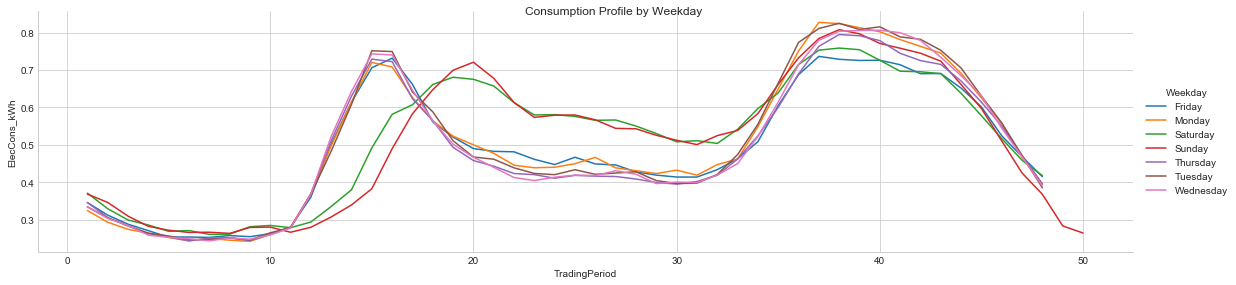

In [39]:
# Plotting the distributions of price against weekday
line_plot(data=kWh_by_weekday_df, group='Weekday', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [54]:
# Creating a dictionary for the weekend flag
weekend_dict = {"Monday": 0, "Tuesday": 0,"Wednesday": 0,"Thursday": 0,"Friday": 0,"Saturday": 1,"Sunday": 1}
meter_df['Weekend'] = meter_df['Weekday'].map(weekend_dict)

count    875950.000000
mean          0.284891
std           0.451363
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Weekend, dtype: float64

##### Creating a public holiday flag

In [15]:
# # Creating a public holiday flag
# def semester(df):
#     if (((df['Date'] >= dt.date(2017, 2, 27)) & (df['Date'] < dt.date(2017, 5, 28))) | ((df['Date'] >= dt.date(2018, 2, 26)) & (df['Date'] < dt.date(2018, 5, 27)))):
#         val = 1
#     elif (((df['Date'] >= dt.date(2017, 7, 24)) & (df['Date'] < dt.date(2017, 10, 22))) | ((df['Date'] >= dt.date(2019, 7, 23)) & (df['Date'] < dt.date(2018, 10, 21)))):
#         val = 1
#     else:
#         val = 0
#     return val

# df['Semester'] = df.apply(semester, axis=1)

## 9. Modelling The Daily Residential Electricity Consumption Profile
---

In [86]:
# Aggregating the consumtion to a total accross all 50 sampled ICPKeys
model_df = pd.DataFrame(meter_df.groupby(['MeterPollDateKey', 'TradingPeriod', 'Season_Int', 'Weekend'])[['ElecCons_kWh']]
                                .sum()
                                .reset_index(level=['MeterPollDateKey', 'TradingPeriod', 'Season_Int', 'Weekend'])
                                .sort_values(by=['TradingPeriod']))

In [87]:
model_df = model_df[['TradingPeriod', 'ElecCons_kWh', 'Season_Int', 'Weekend']]

In [88]:
# # Selecting relevant features (using Semester and Weekend to segment the data as they displayed significantly different behaviour)
# temp_df = df.loc[:,['Time', 'Weekend', 'Semester', 'Maximum temperature (Degree C)', 'kWh']]

# # label encoding the time of day feature
# temp_df['Time'] = temp_df['Time'].astype(str)
# temp_df['Time'] = LabelEncoder().fit(temp_df['Time']).transform(temp_df['Time']) 

In [89]:
# Defining a model fitting function
def model_fit(mdl, mdl_nme='', df=None, tgt_var=None, n_fld=5, output=True):   
    if output:
        print(f"{mdl_nme} fit")
              
    # K fold validation
    fld = KFold(n_splits=n_fld, shuffle=True, random_state=42)
    
    # List of feature columns
    fts = [f for f in df.columns if f not in [tgt_var]]
    
    # Initializing Variables
    prd = np.zeros(df[fts].shape[0])
    ful_prd = np.zeros(df[fts].shape[0])
    RMSE = 0
    MSE = 0
    RMSE_tot = 0
    MSE_tot = 0
    
    for n_fold, (trn_idx, vld_idx) in enumerate(fld.split(df[fts], df[tgt_var])):
        trn_X, trn_y = df[fts].iloc[trn_idx], df[tgt_var].iloc[trn_idx]
        vld_X, vld_y = df[fts].iloc[vld_idx], df[tgt_var].iloc[vld_idx]
        # Fit the model
        mdl.fit(trn_X, trn_y)
        
        prd[vld_idx] = mdl.predict(vld_X)
            
        # Appling the fit to the prediction set
        ful_prd += mdl.predict(df[fts])/fld.n_splits

        # Outputting the AUC
        MSE = mean_squared_error(vld_y, mdl.predict(vld_X))
        MSE_tot += MSE/fld.n_splits
        RMSE = np.sqrt(MSE)
        
        # Outputting statistics
        if output:
            print('Fold %2d RMSE : %.6f' % (n_fold + 1, RMSE))
    
    RMSE_tot = np.sqrt(MSE_tot)
    if output:
        print('RMSE over folds: %.6f' % RMSE_tot)

    return RMSE_tot, ful_prd

In [90]:
# Methodology based off Will Koehrsens Medium post: https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed
# Set lower and upper quantile
lower = 0.05
upper = 0.99

# Calculate the best fit
gbr = GradientBoostingRegressor(random_state=42)
loss, expected_kWh = model_fit(gbr, 'Gradient Boosting Regressor', model_df, 'ElecCons_kWh')
model_df['Expected_ElecCons_kWh'] = expected_kWh

# Calculate the lower 5th percential
gbr_5 = GradientBoostingRegressor(loss="quantile", alpha=0.05, random_state=42)
loss, kWh_5th = model_fit(gbr_5, 'Lower 5 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['5th_ElecCons_kWh'] = kWh_5th

# Calculate the lower 12.5th percential
gbr_25 = GradientBoostingRegressor(loss="quantile", alpha=0.25, random_state=42)
loss, kWh_25th = model_fit(gbr_25, 'Lower 25 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['25th_ElecCons_kWh'] = kWh_25th

# Calculate the upper 75th percential
gbr_75 = GradientBoostingRegressor(loss="quantile", alpha=0.75, random_state=42)
loss, kWh_75th = model_fit(gbr_75, 'Upper 75 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['75th_ElecCons_kWh'] = kWh_75th

# Calculate the upper 95th percential
gbr_95 = GradientBoostingRegressor(loss="quantile", alpha=0.95, random_state=42)
loss, kWh_95th = model_fit(gbr_95, 'Upper 95 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['95th_ElecCons_kWh'] = kWh_95th

Gradient Boosting Regressor fit
Fold  1 RMSE : 4.826320
Fold  2 RMSE : 4.992582
Fold  3 RMSE : 5.039763
Fold  4 RMSE : 5.203765
Fold  5 RMSE : 5.041102
RMSE over folds: 5.022158


In [82]:
def profile_plot(df, fig_name=''):
    
    # Plotting the measured consumption aggregated over all 50 sampled ICPKeys
    plt.plot(df['TradingPeriod'], df['ElecCons_kWh'], 'o', color='seagreen', alpha=0.08);
    
    # Aggregating the consumtion to a average daily profile
    df = pd.DataFrame(df.groupby(['TradingPeriod'])[['5th_ElecCons_kWh', '25th_ElecCons_kWh', 'Expected_ElecCons_kWh', '75th_ElecCons_kWh', '95th_ElecCons_kWh']]
                        .mean()
                        .reset_index(level=['TradingPeriod']))
    
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['5th_ElecCons_kWh'], ':', color='mediumblue', label = "5th percential", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['25th_ElecCons_kWh'], '--', color='mediumblue', label = "25th percential", linewidth=2)
    # Plotting the best fit
    plt.plot(df['TradingPeriod'], df['Expected_ElecCons_kWh'], '-', color='black', label = "Best Fit", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['75th_ElecCons_kWh'], '--', color='mediumblue', label = "75th percential", linewidth=2)
    # Plotting the 95th percentile
    plt.plot(df['TradingPeriod'], df['95th_ElecCons_kWh'], ':', color='mediumblue', label = "95th percentile", linewidth=2)

    # Setting the title axies and legend
    plt.xlabel('Trading Period', size=14)
    plt.ylabel('Electricity Consumption (kWh)', size=14)
    plt.title(f"Residential Electricity Consumption Profile {fig_name}", size=20)
    plt.legend()

    # Display and save the figure.
    fig = plt.gcf()
    fig.set_size_inches(16, 6, forward=True)
    fig.savefig(f"figures/Electricity-Consumption-Profile_{fig_name}.png", dpi=100)

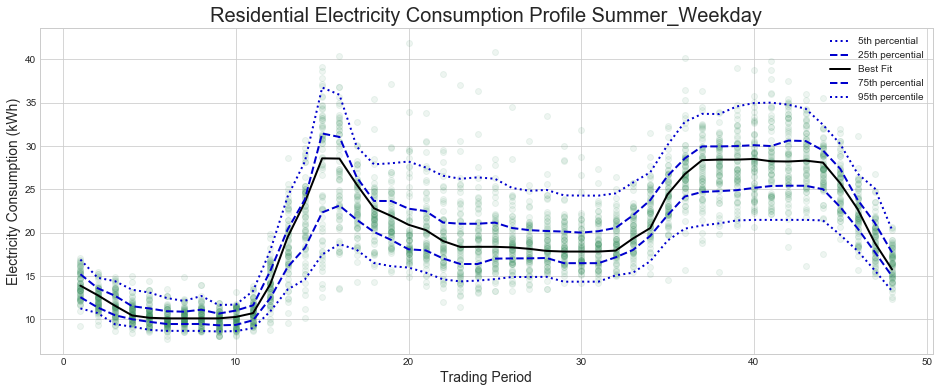

In [91]:
summer_weekday_df = model_df.where((model_df.Season_Int == 0) & (model_df.Weekend == 0))
profile_plot(summer_weekday_df, fig_name='Summer_Weekday')

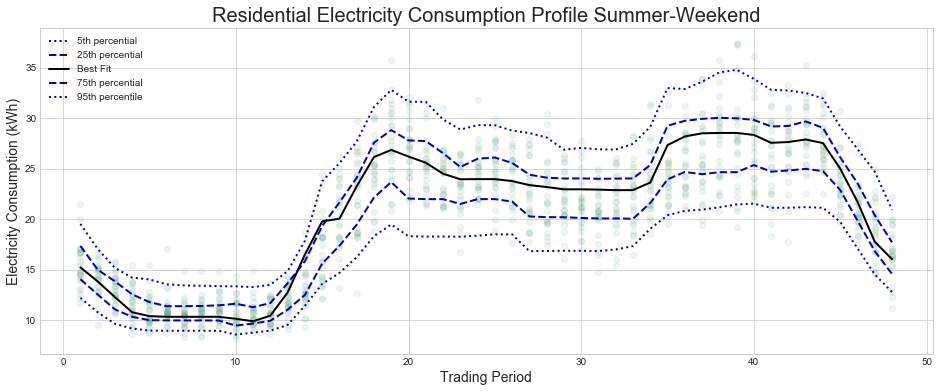

In [93]:
summer_weekend_df = model_df.where((model_df.Season_Int == 0) & (model_df.Weekend == 1))
profile_plot(summer_weekend_df, fig_name='Summer-Weekend')

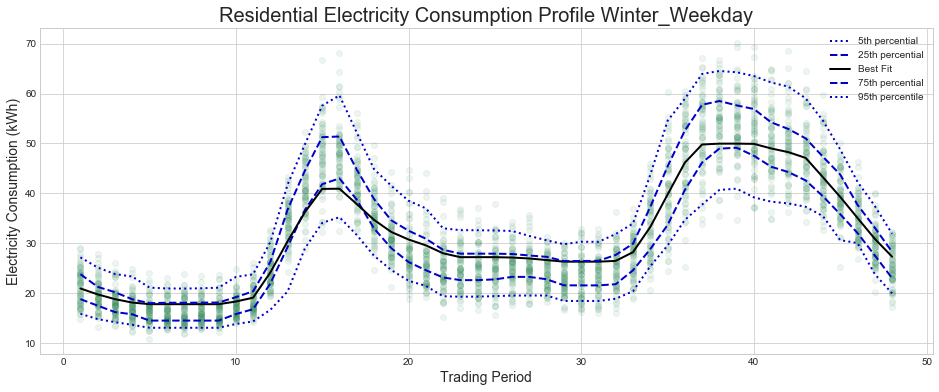

In [94]:
winter_weekday_df = model_df.where((model_df.Season_Int == 1) & (model_df.Weekend == 0))
profile_plot(winter_weekday_df, fig_name='Winter_Weekday')

In [172]:
# # Creating an list of legend items to order by
# legend_order = [dt.time(0, 0), dt.time(0, 30), dt.time(1, 0), dt.time(1, 30), dt.time(2, 0), dt.time(2, 30), dt.time(3, 0), dt.time(3, 30), dt.time(4, 0), dt.time(4, 30), dt.time(5, 0), dt.time(5, 30), dt.time(6, 0)
#                 , dt.time(6, 30), dt.time(7, 0), dt.time(7, 30), dt.time(8, 0), dt.time(8, 30), dt.time(9, 0), dt.time(9, 30), dt.time(10, 0), dt.time(10, 30), dt.time(11, 0), dt.time(11, 30), dt.time(12, 0), dt.time(12, 30)
#                 , dt.time(13, 0), dt.time(13, 30), dt.time(14, 0), dt.time(14, 30), dt.time(15, 0), dt.time(15, 30), dt.time(16, 0), dt.time(16, 30), dt.time(17, 0), dt.time(17, 30), dt.time(18, 0), dt.time(18, 30)
#                 , dt.time(19, 0), dt.time(19, 30), dt.time(20, 0), dt.time(20, 30), dt.time(21, 0), dt.time(22, 30), dt.time(23, 0), dt.time(23, 30)]

## 14. Summary
---